In [1]:
import pandas as pd
from pycaret.classification import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# 1. Cargar la data
df = pd.read_csv("taller2_MLE.csv")

In [2]:
df.head()  

,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region,cerrara_cuenta
0,48,Preferente,43791.80,5,11,0,1,1,4.2,36.82,Medio,Sierra,0
1,36,Estándar,17940.87,1,7,0,1,0,2.2,39.78,Muy Alto,Selva,0
2,48,Estándar,9308.09,4,3,0,1,1,1.0,28.36,Medio,Sierra,1
3,30,Estándar,709.76,5,5,1,1,0,5.0,45.73,Bajo,Selva,0
4,74,Preferente,20471.46,1,4,0,0,1,3.1,39.19,Medio,Sierra,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   edad                   5000 non-null   int64  
 1   segmento               5000 non-null   object 
 2   saldo_total            5000 non-null   float64
 3   numero_productos       5000 non-null   int64  
 4   visitas_app_mes        5000 non-null   int64  
 5   usa_web                5000 non-null   int64  
 6   usa_tarjeta_credito    5000 non-null   int64  
 7   reclamos_6m            5000 non-null   int64  
 8   satisfaccion_encuesta  5000 non-null   float64
 9   tasa_credito_personal  5000 non-null   float64
 10  rango_ingresos         5000 non-null   object 
 11  region                 5000 non-null   object 
 12  cerrara_cuenta         5000 non-null   int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 507.9+ KB


### **Pregunta 01:**  ¿Cuál es el porcentaje de clientes que cerraron su cuenta? ¿Está balanceado el dataset?

In [4]:
df['cerrara_cuenta'].value_counts(normalize=True)*100

cerrara_cuenta
0    85.96
1    14.04
Name: proportion, dtype: float64

##### **Respuesta :** El dataset esta desbalanceado, presenta 14% de clientes con tendencia a cerrar su cuenta.

### **Pregunta 02:** ¿Qué variables tienen mayor correlación con cerrara_cuenta?

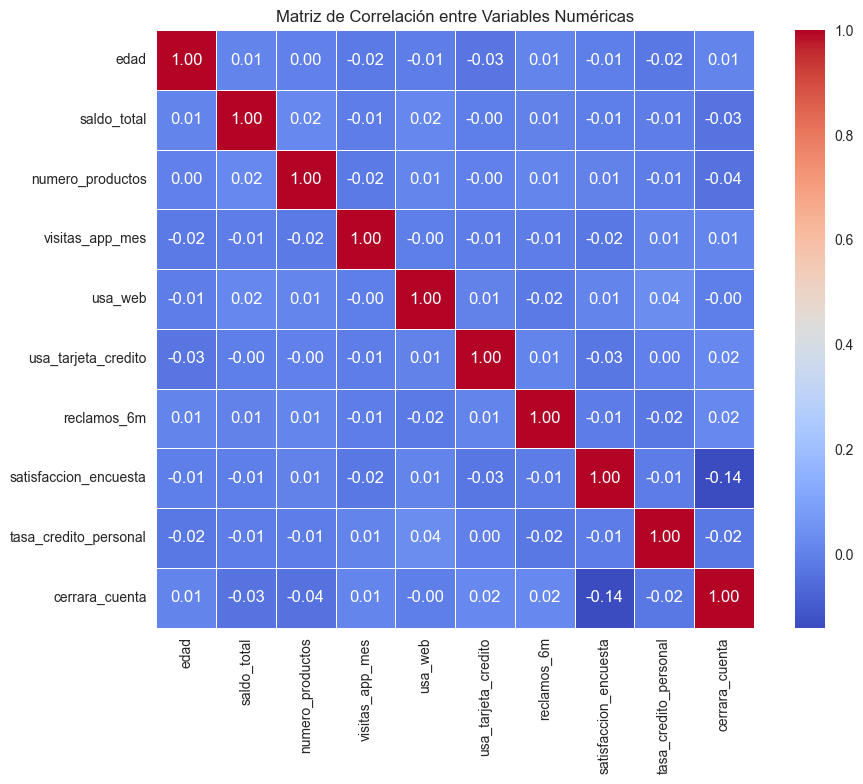

In [5]:
# Filtrar solo variables numéricas
numerical_vars = df.select_dtypes(include=['int64', 'float64'])

# Calcular matriz de correlación
corr_matrix = numerical_vars.corr()

# Crear heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.tight_layout()
plt.show()

#### **Respuesta:** Existe una mayor correlación negativa entre la satisfacción del cliente con que el cliente cierre su cuenta.

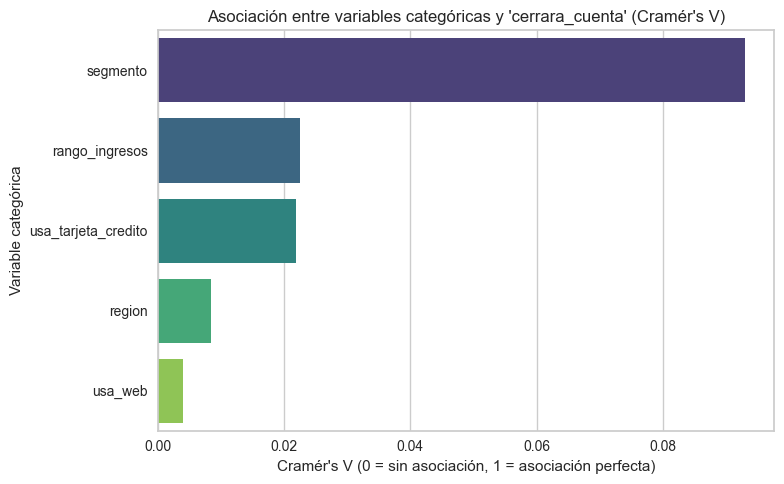

In [6]:
# Función para calcular Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Lista de variables categóricas
cat_vars = ['segmento', 'rango_ingresos', 'region', 'usa_web', 'usa_tarjeta_credito']

# Calcular Cramér's V entre cada variable y 'cerrara_cuenta'
cramers_v_values = {}
for var in cat_vars:
    confusion_mat = pd.crosstab(df[var], df['cerrara_cuenta'])
    cramers_v_values[var] = cramers_v(confusion_mat)

# Convertir a DataFrame para graficar
cramer_df = pd.DataFrame.from_dict(cramers_v_values, orient='index', columns=['Cramér\'s V']).sort_values(by="Cramér's V", ascending=False)

# Graficar
plt.figure(figsize=(8, 5))
sns.barplot(x=cramer_df["Cramér's V"], y=cramer_df.index, palette='viridis')
plt.title("Asociación entre variables categóricas y 'cerrara_cuenta' (Cramér's V)")
plt.xlabel("Cramér's V (0 = sin asociación, 1 = asociación perfecta)")
plt.ylabel("Variable categórica")
plt.tight_layout()
plt.show()

#### **Respuesta:** Existe una relación positiva entre el segmento con la tendencia a cerrar cuenta.

### **Pregunta 03:** ¿Cuál es el mejor modelo en AUC? ¿Y en Recall?

In [7]:
# Discretización manual en 4 bins por cuartiles
df['edad_binned'] = pd.qcut(df['edad'], q=4, labels=False)
df['saldo_total_binned'] = pd.qcut(df['saldo_total'], q=4, labels=False)
df['tasa_credito_binned'] = pd.qcut(df['tasa_credito_personal'], q=4, labels=False)


In [8]:
clf = setup(data=df,
            target='cerrara_cuenta',
            session_id=2025,
            categorical_features=['segmento', 'rango_ingresos', 'region', 'usa_web', 'usa_tarjeta_credito',
                                  'edad_binned', 'saldo_total_binned', 'tasa_credito_binned'],
            transformation=True,
            polynomial_features=True,
            remove_multicollinearity=True,
            multicollinearity_threshold=0.85,
            verbose=False)


In [9]:
best_model = compare_models(sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5617,0.5692,0.5276,0.1670,0.2536,0.0510,0.0666,0.7480
dt,Decision Tree Classifier,0.7557,0.5299,0.2160,0.1820,0.1971,0.0544,0.0549,0.7430
svm,SVM - Linear Kernel,0.8346,0.6087,0.0853,0.2777,0.0990,0.0483,0.0641,0.9270
lda,Linear Discriminant Analysis,0.8443,0.5869,0.0550,0.2621,0.0899,0.0421,0.0590,0.7020
qda,Quadratic Discriminant Analysis,0.8257,0.5279,0.0549,0.1424,0.0707,0.0067,0.0054,0.7640
ada,Ada Boost Classifier,0.8543,0.6021,0.0388,0.3239,0.0676,0.0407,0.0684,0.9420
knn,K Neighbors Classifier,0.8437,0.5277,0.0326,0.1908,0.0548,0.0133,0.0206,1.7240
et,Extra Trees Classifier,0.8469,0.5772,0.0244,0.2044,0.0426,0.0088,0.0181,0.8460
gbc,Gradient Boosting Classifier,0.8554,0.6118,0.0204,0.2067,0.0366,0.0191,0.0321,1.3200
lightgbm,Light Gradient Boosting Machine,0.8480,0.5816,0.0162,0.1722,0.0290,0.0003,0.0049,1.0470


#### **Respuesta :** El modelo que mejor Recall presenta es el de Naive Bayes; mientras que el que mejor AUC presenta es el de Regresión Logística. 

### **Pregunta 04:** ¿Qué combinación de variables permite identificar clientes silenciosos que se van (sin reclamos)?

In [10]:
clientes_silenciosos = df[(df['cerrara_cuenta'] == 1) & (df['reclamos_6m'] == 0)]
clientes_silenciosos.head(3)

,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region,cerrara_cuenta,edad_binned,saldo_total_binned,tasa_credito_binned
26,43,Preferente,9200.10,3,8,1,0,0,2.4,39.72,Bajo,Costa,1,1,0,2
47,55,Estándar,0.00,1,2,1,1,0,3.4,37.96,Bajo,Costa,1,2,0,2
49,46,Estándar,35916.27,4,6,0,1,0,2.7,35.12,Medio,Selva,1,1,3,1


#### **Respuesta**: La combinación de variables que permite identificar aquellos clientes silenciosos es la variable Cerrara_cuenta con la de reclamo_6m. Es decir, cliente que se fueron sin presentar ningún reclamos en los últimos 6 meses.

### **Pregunta 05:** Qué pasa si el modelo predice mal un cliente que no se iba (falso positivo)? ¿Y uno que sí se iba (falso negativo)

Un falso positivo ocurre cuando el modelo señala que un cliente abandonará la empresa, pero en realidad no lo hará. Esto puede llevar a realizar acciones de retención innecesarias, generando costos adicionales o incluso incomodidad en el cliente al sentirse presionado sin motivo.
Por otro lado, un falso negativo implica que el modelo no identifica a un cliente que sí tiene intención de irse, lo que se traduce en una oportunidad perdida para retenerlo y, por tanto, en una pérdida directa para el negocio.
Dado su impacto, los falsos negativos son más críticos en este caso, por lo que conviene ajustar el modelo para priorizar una mayor sensibilidad (recall) y así captar la mayor cantidad posible de clientes en riesgo real de fuga.

### **Pregunta 06:** ¿Qué umbral de score (default 0.5 vs optimizado por KS) deberías usar para reducir la pérdida financiera?

Aunque el umbral por defecto de 0.5 es común, no siempre es el más adecuado para reducir pérdidas financieras. Este valor clasifica como fuga a cualquier cliente con una probabilidad mayor al 50%, sin considerar el costo de los errores.

En cambio, usar un umbral optimizado mediante el estadístico KS (Kolmogorov-Smirnov) permite identificar el punto donde el modelo separa mejor a los que se van de los que se quedan. Esto ayuda a detectar con mayor precisión a los clientes en riesgo real, incluso si eso implica asumir más falsos positivos.

Por tanto, para minimizar la pérdida financiera por fuga no detectada, se recomienda usar el umbral optimizado por KS, ya que prioriza la sensibilidad del modelo y permite actuar a tiempo con campañas de retención más efectivas.

### 7. ¿Cómo explicarías con SHAP que un cliente Premium con buen saldo igual fue predicho como fuga? 

In [11]:
df['segmento'].unique()

array(['Preferente', 'Estándar', 'Premium'], dtype=object)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8629,0.5929,0.0204,1.0000,0.0400,0.0346,0.1327
1,0.8571,0.6403,0.0000,0.0000,0.0000,-0.0056,-0.0216
2,0.8600,0.5531,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.8600,0.5504,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8571,0.6123,0.0000,0.0000,0.0000,-0.0056,-0.0216
5,0.8600,0.5504,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.8600,0.6051,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.8600,0.5990,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8571,0.6357,0.0000,0.0000,0.0000,-0.0056,-0.0216


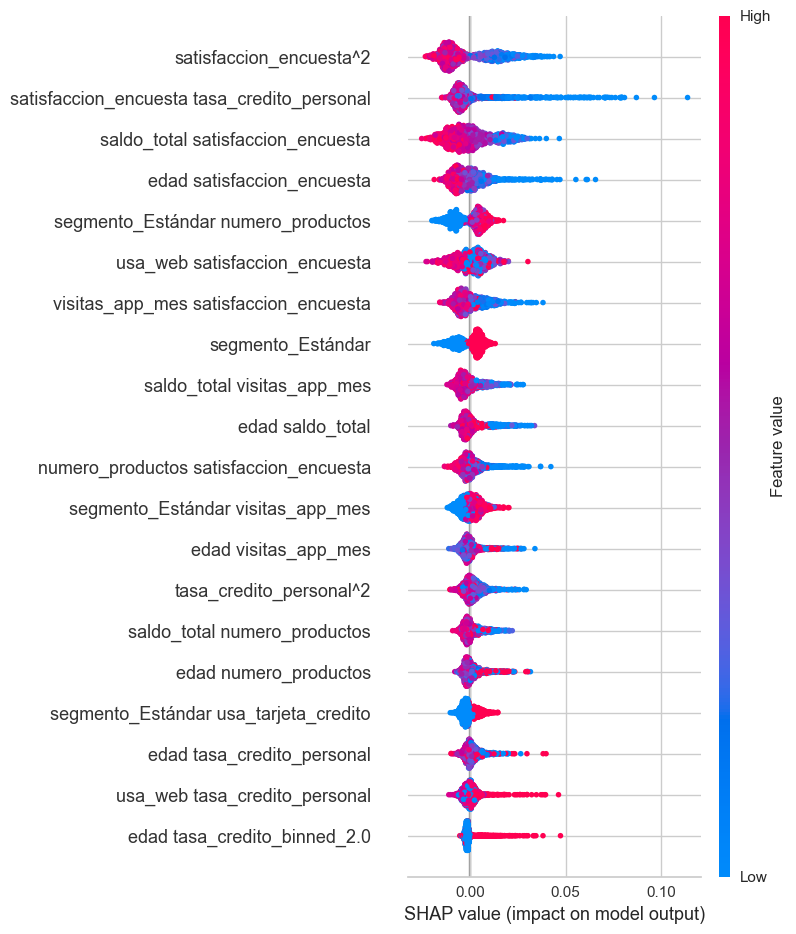

In [12]:
model = create_model('rf')  # Usa Random Forest
interpret_model(model, plot='summary')


Aunque el cliente pertenece al segmento Premium y presenta un buen saldo total, el modelo también considera otras variables de mayor peso relativo en la predicción de fuga.

Según el gráfico SHAP:

La satisfacción de la encuesta (satisfaccion_encuesta) y sus interacciones son las variables con mayor impacto. Si este cliente tiene una satisfacción baja (color azul a la derecha del eje), esto empuja fuertemente la predicción hacia la fuga.

También influye el uso limitado de canales digitales, como pocas visitas a la app y no usar la web. Esto se ve reflejado en las combinaciones usa_web satisfaccion_encuesta, visitas_app_mes satisfaccion_encuesta, etc. Si este cliente Premium no interactúa digitalmente, se interpreta como desinterés o desconexión.

La combinación segmento_Estándar y numero_productos también tiene peso: aunque el cliente sea Premium, si su número de productos contratados es bajo, el valor relacional puede ser débil, lo que inclina la predicción hacia fuga.

Edad y tasa de crédito aparecen como moderadores importantes. Si el cliente es mayor pero no usa crédito o tiene tasa baja, eso también puede contribuir negativamente.

En resumen, el modelo no evalúa al cliente solo por el saldo o el segmento, sino por un conjunto de comportamientos y percepciones combinadas. Un cliente Premium con alto saldo pero con baja satisfacción, poco uso digital y pocos productos contratados será considerado con alta probabilidad de fuga.

### 8. ¿Debería el modelo incluir la tasa de interés ofrecida como predictor, si luego esta puede cambiar según la política de retención? 

Depende del objetivo del modelo. Si el modelo busca predecir la propensión a la fuga antes de activar cualquier política de retención, entonces sí es válido incluir la tasa de interés ofrecida inicialmente, ya que refleja la condición actual del cliente antes de cualquier intervención.

Sin embargo, si el modelo se usará para evaluar escenarios después de aplicar una política de retención (por ejemplo, mejorar la tasa ofrecida), entonces:

La tasa de interés se convierte en una variable manipulable.

Incluirla sin control puede generar confusión o sesgo en las decisiones, especialmente si luego será modificada.

En ese caso, se recomienda:

Tratar la tasa como una variable de intervención futura, no como predictor directo.

Usar modelos de what-if o simulación para evaluar cómo cambios en la tasa afectarán la predicción de fuga.

### 9. ¿Cómo usarías este modelo en un sistema de reglas mixtas (modelo + regla de  negocio) para que los gestores humanos no pierdan confianza?

Para garantizar que los gestores humanos confíen en el sistema de decisiones mixtas, es clave combinar la predicción del modelo con reglas de negocio explícitas y comprensibles. Aquí algunos pasos prácticos:

🔧 1. Definir reglas base claras y aceptadas
Antes de usar el modelo, establece reglas mínimas de elegibilidad o criterios claros que los gestores ya conocen (ej. “clientes con saldo > S/10,000 y más de 3 productos no serán marcados como fuga automáticamente”).

🤖 2. Usar el modelo como alerta, no como mandato
El modelo debe sugerir riesgos, no imponer acciones. Por ejemplo:

“Cliente con 75% probabilidad de fuga, baja satisfacción, y no usa la app desde hace 3 meses”

Esto permite que el gestor tome la decisión final, usando su criterio.

🧠 3. Explicar la predicción con SHAP o razones simples
Mostrar al gestor por qué el modelo predijo fuga:

“Satisfacción baja”

“No usa canales digitales”

“Menos de 2 productos contratados”

Esto aumenta la transparencia y la percepción de justicia del sistema.

⚖️ 4. Permitir la retroalimentación humana
Si un gestor considera que el modelo se equivocó, debe poder marcarlo y enviar feedback. Eso:

Mejora el modelo con el tiempo

Aumenta la confianza en el sistema

📊 5. Medir impactos y mostrar resultados

Demuestra a los gestores que seguir las sugerencias del modelo mejora la retención en términos reales. La evidencia refuerza la confianza.